In [81]:
import sys
sys.path.insert(0,'..')
import eeg_decoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup data loader

In [36]:
experiment_name = 'test_exp'
data_dir = f'../../archery/analysis/data/1801/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-100,1000])

# First let's plot ERPs

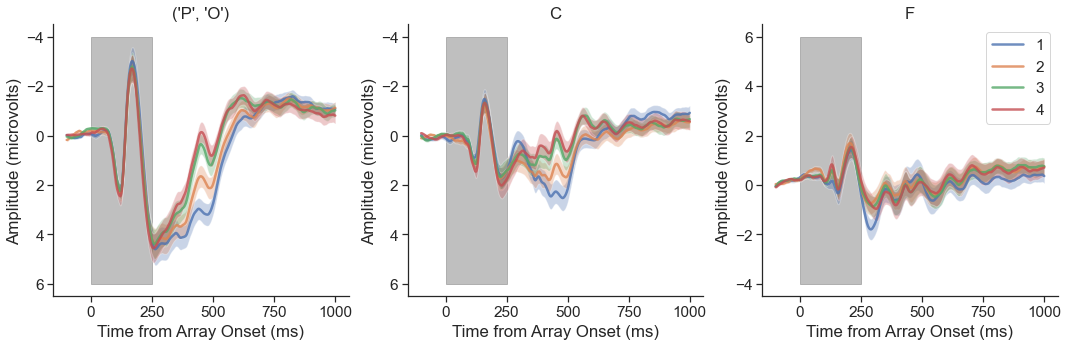

In [82]:
erp = eeg_decoder.ERP(exp,subtitle=experiment_name)
xdata_all, ydata_all = erp.load_all_eeg()

fig,axes = plt.subplots(1,3,figsize=(18,5))
for i,subset in enumerate([('P','O'),('C'),('F')]):
    erp.plot_ss(xdata_all,ydata_all,electrode_subset=subset,savefig=False,ax=axes[i])
    axes[i].set_title(subset)
    axes[i].invert_yaxis()
plt.legend()
plt.show()

ERPs look nice but the individual trials are really noisy

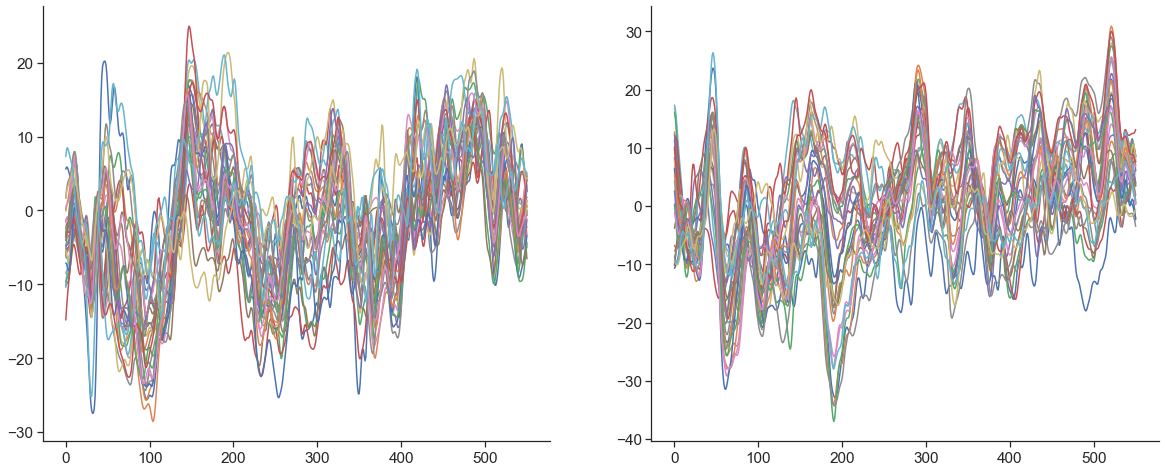

In [88]:
_,axes = plt.subplots(1,2,figsize=(20,8))
axes[0].plot(xdata[10].T);
axes[1].plot(xdata[11].T);
plt.show()

# Now let's decode one participant
First, we load their data

In [44]:
x,y = exp.load_eeg(0)
print(x.shape,y.shape)

(1463, 30, 551) (1463,)


Let's focus on set size 1 vs 3

In [42]:
idx = (y==1) | (y==3)
x,y = x[idx],y[idx]
y -= 1
print(x.shape,y.shape)

(731, 30, 551) (731,)


Remember the train/test split from earlier?

In [10]:
from sklearn.model_selection import train_test_split

X_train_all, X_test_all, y_train, y_test = train_test_split(x,y,stratify=y)
X_train_all.shape

(548, 30, 551)

And here we make our shuffled baseline.

In [11]:
y_test_shuffle = np.random.permutation(y_test)

Now, let's "roll" over time. I typically use 25 ms windows and 25 ms steps.

In [12]:
samples = exp.info['times']
sample_step = 2
time_window = 25
time_step = 25
t = samples[0:samples.shape[0] - int(time_window/sample_step)+1:int(time_step/sample_step)]
print(t)

[-100  -76  -52  -28   -4   20   44   68   92  116  140  164  188  212
  236  260  284  308  332  356  380  404  428  452  476  500  524  548
  572  596  620  644  668  692  716  740  764  788  812  836  860  884
  908  932  956]


This is a generator function. Each time you call it, it will yield the next step. In this case, it's the next window in time.

In [13]:
def roll_over_time(X_train_all, X_test_all):
    for itime, time in enumerate(t):
            time_window_idx = (samples >= time) & (
                samples < time + time_window)

            # Data for this time bin
            X_train = np.mean(X_train_all[..., time_window_idx], 2)
            X_test = np.mean(X_test_all[..., time_window_idx], 2)
            yield X_train, X_test, itime

Let's grab a time from the middle of the stimulus display.

In [14]:
for X_train, X_test, itime in roll_over_time(X_train_all, X_test_all):
    if itime == 10:
        break


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)

In [22]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Fit the model, score the model. Also, score the model using the random y_test.

In [58]:
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
print(model.score(X_test,y_test_shuffle))


0.5969387755102041
0.44387755102040816


# Training/testing over time
That's just at one time point, so now we "roll" over time and fit and score the model for each time window.

In [100]:
acc = np.empty(len(t))
acc_shuffle = np.empty(len(t))

for X_train, X_test, itime in roll_over_time(X_train_all, X_test_all):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train,y_train)
    acc[itime] = model.score(X_test,y_test)
    acc_shuffle[itime] = model.score(X_test,y_test_shuffle)

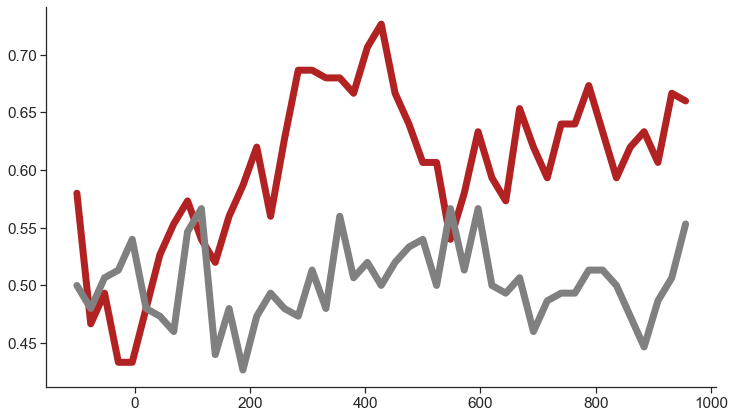

In [102]:
plt.subplots(figsize=(12,7))
plt.plot(t,acc,linewidth=7,c='firebrick')
plt.plot(t,acc_shuffle,linewidth=7,c='grey')
plt.show()

Pretty noisy. That's because it's one participant and one train/test split.

# Now let's add some more cross-validation loops

In [104]:
n_splits = 100
acc = np.empty((n_splits,len(t)))
acc_shuffle = np.empty((n_splits,len(t)))

for ifold in range(n_splits):
    X_train_all, X_test_all, y_train, y_test = train_test_split(x,y,stratify=y)
    y_test_shuffle = np.random.permutation(y_test)
    
    for X_train, X_test, itime in roll_over_time(X_train_all, X_test_all):
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train,y_train)
        acc[ifold,itime] = model.score(X_test,y_test)
        acc_shuffle[ifold,itime] = model.score(X_test,y_test_shuffle)

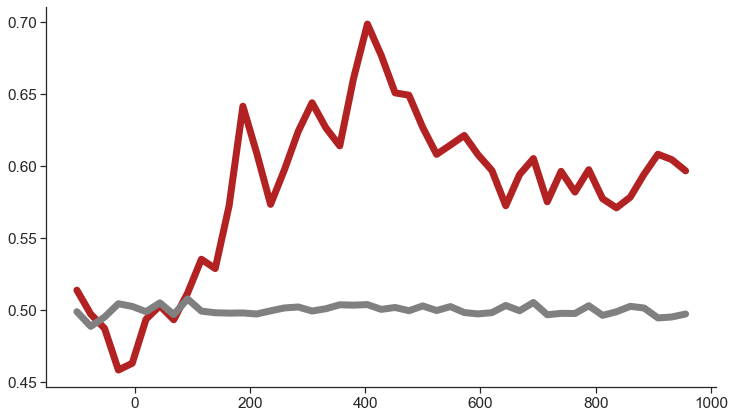

In [105]:
plt.subplots(figsize=(12,7))
plt.plot(t,np.mean(acc,0),linewidth=7,c='firebrick')
plt.plot(t,np.mean(acc_shuffle,0),linewidth=7,c='grey')
plt.show()

Looks way clearer now! But remember, this is all within one subject. So now, let's do this same process for each subject. 

# Now let's add other subjects

In [106]:
from sklearn.metrics import confusion_matrix

n_splits = 10
acc = np.empty((exp.nsub,n_splits,len(t)))
acc_shuffle = np.empty((exp.nsub,n_splits,len(t)))
conf = np.empty((exp.nsub,n_splits,len(t),2,2))

for isub in range(exp.nsub):
    print(isub)
    x,y = exp.load_eeg(isub)
    
    idx = (y==1) | (y==3)
    x,y = x[idx],y[idx]
    y -= 1

    for ifold in range(n_splits):
        X_train_all, X_test_all, y_train, y_test = train_test_split(x,y,stratify=y)
        y_test_shuffle = np.random.permutation(y_test)
        
        for X_train, X_test, itime in roll_over_time(X_train_all, X_test_all):
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model.fit(X_train,y_train)
            acc[isub,ifold,itime] = model.score(X_test,y_test)
            acc_shuffle[isub,ifold,itime] = model.score(X_test,y_test_shuffle)
            conf[isub,ifold,itime] = confusion_matrix(y_test, model.predict(X_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [63]:
acc.shape

(33, 10, 45)

In [67]:
acc_mean = np.mean(acc,1)
acc_mean_shuffle = np.mean(acc_shuffle,1)
acc_grand_mean = np.mean(acc_mean,0)
acc_grand_mean_shuffle = np.mean(acc_mean_shuffle,0)

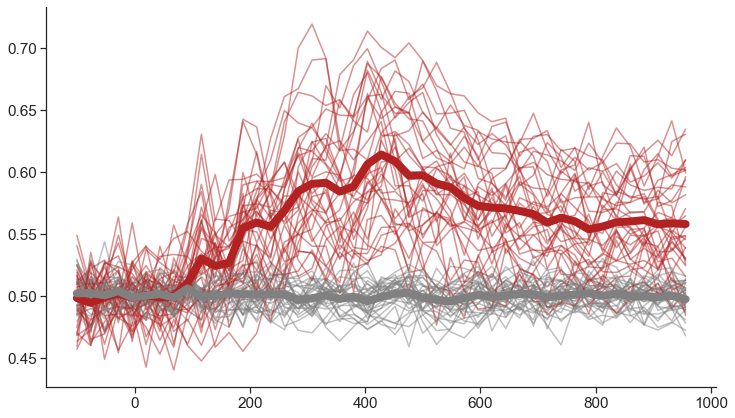

In [139]:
import matplotlib.patheffects as pe
plt.subplots(figsize=(12,7))

for isub in range(exp.nsub):
    plt.plot(t,acc_mean[isub],color='firebrick',alpha=.5)
    plt.plot(t,acc_mean_shuffle[isub],c='grey',alpha=.5)
    
plt.plot(t,acc_grand_mean,c='firebrick',linewidth=8)
plt.plot(t,acc_grand_mean_shuffle,c='grey',linewidth=8)
plt.show()

# Confusion matrix

In [107]:
conf.shape

(33, 10, 45, 2, 2)

In [130]:
mean_conf = np.mean(np.mean(np.mean(conf[:,:,t>0],2),1),0)

def plot_cm(cm,center=None,vmin=None,vmax=None,colormap=None):
    ax = sns.heatmap(cm,
                    center=center,
                    vmin=vmin,
                    vmax=vmax,

                    xticklabels=[1,3],
                    yticklabels=[1,3],
                    # non-arg aesthetics
                    cmap=colormap,
                    annot=True,
                    square=True,
                    annot_kws={"fontsize":16},
                    linewidths=.5)

    # Clean up axes
    plt.ylabel('True Label', fontsize=16)
    plt.title('Predicted Label', fontsize=16)
    plt.yticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=15, labelbottom = False, bottom=False, top = False, labeltop=True, left=False)

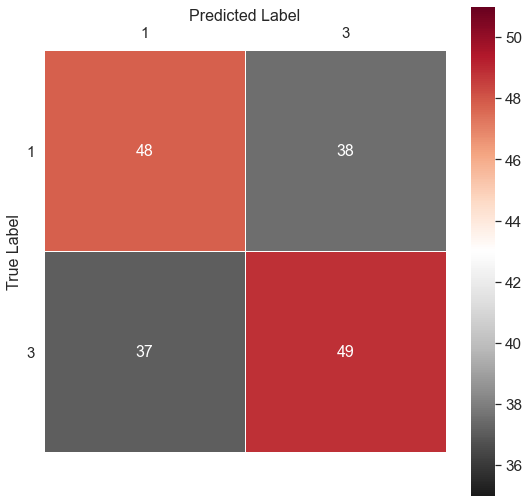

In [132]:
plt.subplots(figsize=(9,9))
plot_cm(mean_conf,vmin=35,vmax=51,colormap=plt.cm.RdGy_r)

In [122]:
# Normalize
mean_conf_norm = mean_conf.astype('float') / mean_conf.sum(axis=1)[:, np.newaxis]

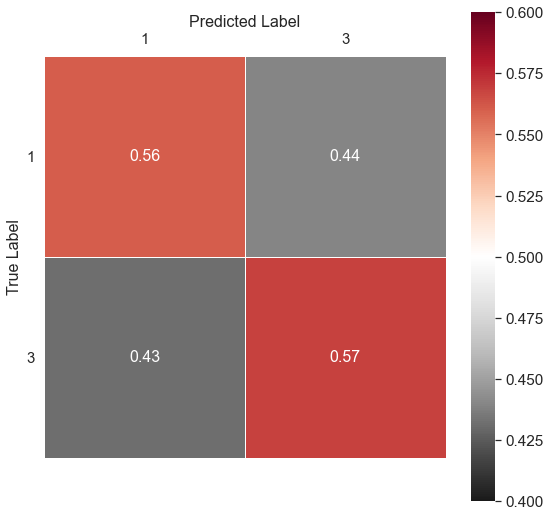

In [134]:
plt.subplots(figsize=(9,9))
plot_cm(mean_conf_norm,center=.5,vmin=.4,vmax=.6,colormap=plt.cm.RdGy_r)